<a href="https://colab.research.google.com/github/deepinderthind11/deepinderthind11/blob/main/FloodPredictionbyDeep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
import time


In [3]:
start_time = time.time()
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(f"Data loading time: {time.time() - start_time} seconds")


Data loading time: 2.344904899597168 seconds


In [4]:
start_time = time.time()
X = train_df.drop(columns=['id', 'FloodProbability'])
y = train_df['FloodProbability']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"Data preparation time: {time.time() - start_time} seconds")


Data preparation time: 1.3186752796173096 seconds


In [5]:
start_time = time.time()
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
score = r2_score(y_valid, y_pred)
print(f"Validation R2 Score: {score}")
print(f"Model training and evaluation time: {time.time() - start_time} seconds")


Validation R2 Score: 0.6555031624976388
Model training and evaluation time: 1031.112977027893 seconds


In [8]:
start_time = time.time()
X_test = test_df.drop(columns=['id'])
X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)
test_predictions = model.predict(X_test_scaled)

submission_df = pd.DataFrame({
    'id': test_df['id'],
    'FloodProbability': test_predictions
})

submission_df.to_csv('/content/best_submission.csv', index=False)
print(f"Prediction and submission time: {time.time() - start_time} seconds")


Prediction and submission time: 109.64729332923889 seconds


In [9]:
from google.colab import files
files.download('/content/best_submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

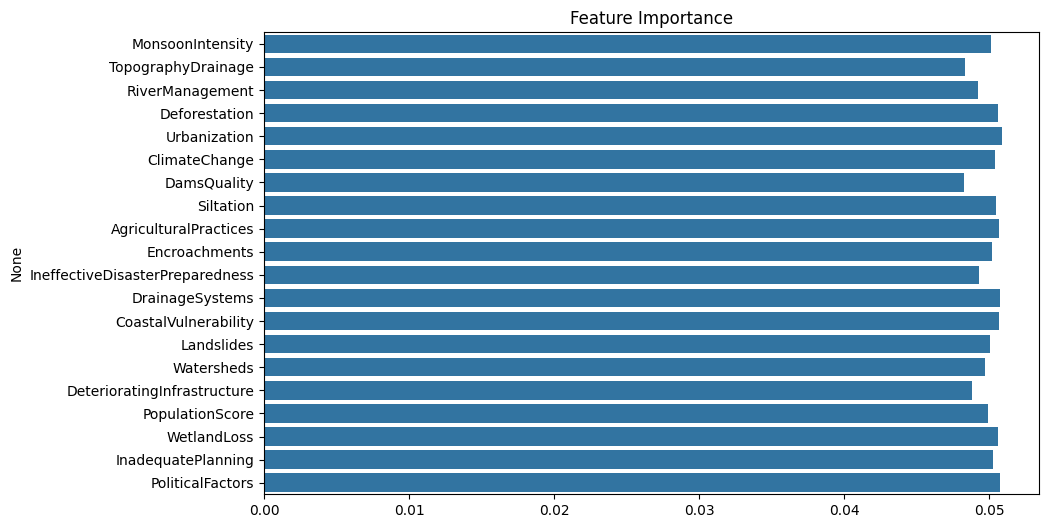

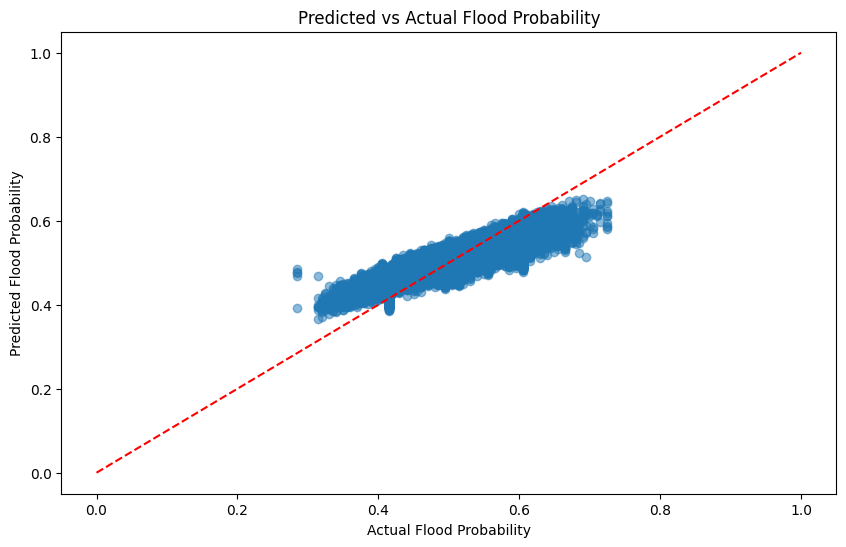

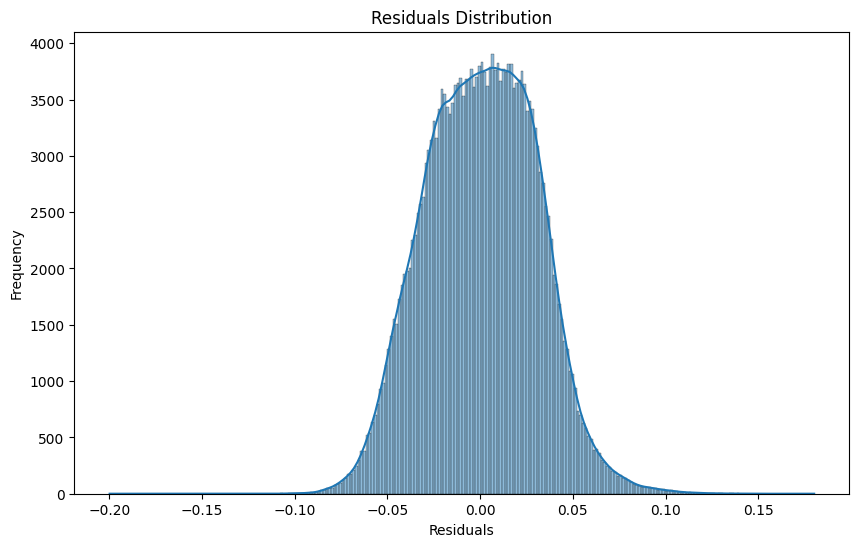

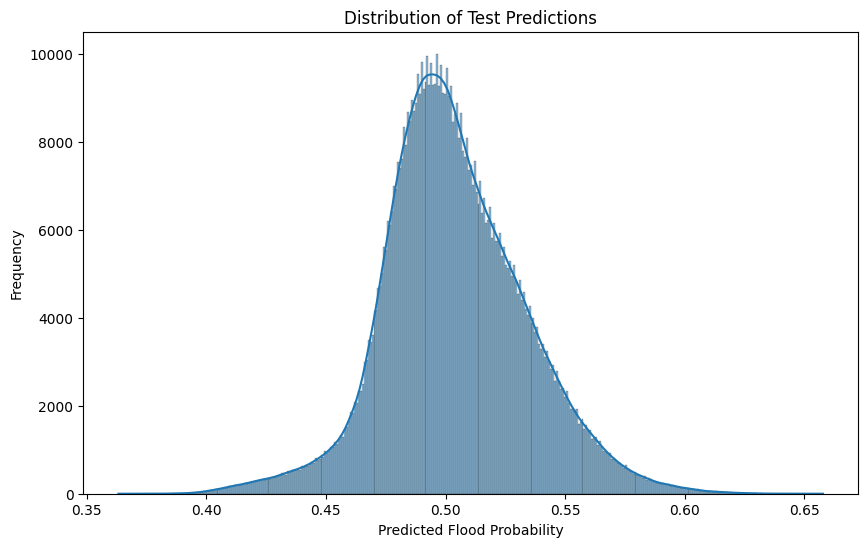

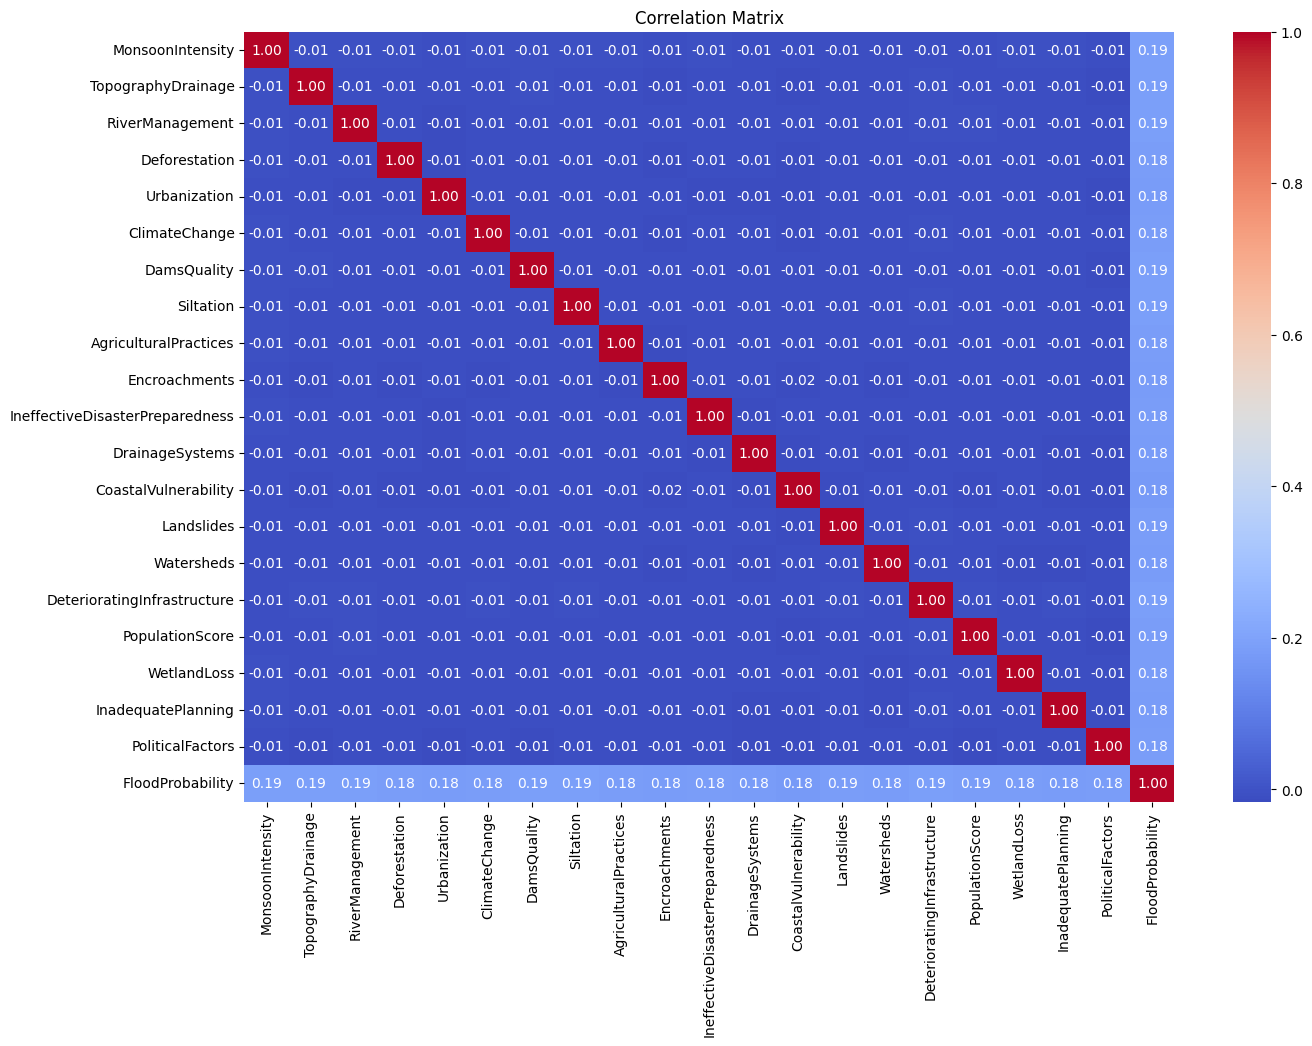

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# Feature Importance
feature_importances = model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importance')
plt.show()

# Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred, alpha=0.5)
plt.xlabel('Actual Flood Probability')
plt.ylabel('Predicted Flood Probability')
plt.title('Predicted vs Actual Flood Probability')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

# Residuals Plot
residuals = y_valid - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Distribution of Predictions
plt.figure(figsize=(10, 6))
sns.histplot(test_predictions, kde=True)
plt.title('Distribution of Test Predictions')
plt.xlabel('Predicted Flood Probability')
plt.ylabel('Frequency')
plt.show()

# Correlation Heatmap
corr_matrix = train_df.drop(columns=['id']).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
